In [32]:
%env CUDA_VISIBLE_DEVICES=-1

import os

import contextlib
from typing import Callable, Mapping, TypeVar, Union

import pyro.distributions.constraints as constraints
import torch

from chirho.explainable.handlers.components import (
    consequent_eq,
    consequent_neq,
    consequent_eq_neq,
    random_intervention,
    sufficiency_intervention,
    undo_split,
    do,
)
from chirho.explainable.handlers.preemptions import Preemptions
#from chirho.interventional.handlers import do
from chirho.interventional.ops import Intervention
from chirho.observational.handlers.condition import Factors

S = TypeVar("S")
T = TypeVar("T")

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import torch


from collections import Counter
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

import pandas as pd
from typing import Callable, Mapping, TypeVar, Union


from chirho.observational.handlers import condition
from chirho.counterfactual.handlers.counterfactual import MultiWorldCounterfactual
from chirho.explainable.handlers import SplitSubsets, SearchForExplanation #, SearchForNS

from chirho.indexed.ops import (IndexSet, gather, indices_of) 


env: CUDA_VISIBLE_DEVICES=-1


In [2]:
def ff_disjunctive():
        match_dropped = pyro.sample("match_dropped", dist.Bernoulli(0.7)) # notice uneven probs here
        lightning = pyro.sample("lightning", dist.Bernoulli(0.4))

        forest_fire = pyro.deterministic("forest_fire", torch.max(match_dropped, lightning), event_dim=0)

        return {"match_dropped": match_dropped, "lightning": lightning,
            "forest_fire": forest_fire}

observations = {"match_dropped": torch.tensor(1.), 
                "lightning": torch.tensor(0.),
                "forest_fire": torch.tensor(1.)}

antecedents = {"match_dropped": torch.tensor(0.0)} 

witnesses = {} # ignore witnesses for now

consequents = {"forest_fire": constraints.boolean}


In [3]:
@contextlib.contextmanager
def SearchForNS(
    antecedents: Union[
        Mapping[str, Intervention[T]],
        Mapping[str, constraints.Constraint],
    ],
    witnesses: Union[
        Mapping[str, Intervention[T]], Mapping[str, constraints.Constraint]
    ],
    consequents: Union[
        Mapping[str, Callable[[T], Union[float, torch.Tensor]]],
        Mapping[str, constraints.Constraint],
    ],
    *,
    antecedent_bias: float = 0.0,
    witness_bias: float = 0.0,
    consequent_scale: float = 1e-2,
    antecedent_prefix: str = "__antecedent_",
    witness_prefix: str = "__witness_",
    consequent_prefix: str = "__consequent_",
    intervention_postfix = "",
):
    """
    # TODO revise this docstring
    Effect handler used for causal explanation search. On each run:

      1. The antecedent nodes are intervened on with the values in ``antecedents`` \
        using :func:`~chirho.counterfactual.ops.split` . \
        Unless alternative interventions are provided, \
        counterfactual values are uniformly sampled for each antecedent node \
        using :func:`~chirho.explainable.internals.uniform_proposal` \
        given its support as a :class:`~pyro.distributions.constraints.Constraint`.

      2. These interventions are randomly :func:`~chirho.explainable.ops.preempt`-ed \
        using :func:`~chirho.explainable.handlers.undo_split` \
        by a :func:`~chirho.explainable.handlers.SplitSubsets` handler.

      3. The witness nodes are randomly :func:`~chirho.explainable.ops.preempt`-ed \
        to be kept at the values given in ``witnesses``.

      4. A :func:`~pyro.factor` node is added tracking whether the consequent nodes differ \
        between the factual and counterfactual worlds.

    :param antecedents: A mapping from antecedent names to interventions or to constraints.
    :param witnesses: A mapping from witness names to interventions or to constraints.
    :param consequents: A mapping from consequent names to factor functions or to constraints.
    """

    # intervention_names will disentangle antecedent interventions
    # from potential interventions on antecedent nodes upstream
    # and allow for programmatic indexing into counterfactual worlds
    # within consequent eq_neq
    

    intervention_names = {f"{antecedent}{intervention_postfix}" for antecedent in antecedents.keys()}

    if antecedents and isinstance(
        next(iter(antecedents.values())),
        constraints.Constraint,
    ):
        
        antecedents_supports = {a: s for a, s in antecedents.items()}

        antecedents = {
            a: (
                random_intervention(s, name=f"{antecedent_prefix}_proposal_{a}"),
                sufficiency_intervention(intervention_names),
            )
            for a, s in antecedents_supports.items()
        }

    else:
        
        antecedents_supports = {a: constraints.boolean for a in antecedents.keys()}
        # TODO generalize to non-scalar antecedents
        # comment: how about extracting supports? 
        
        antecedents = {
            a: (
                antecedents[a], 
                sufficiency_intervention(intervention_names)
                )
             
            for a, s in antecedents_supports.items()
        }


    if witnesses and isinstance(
        next(iter(witnesses.values())),
        constraints.Constraint,
    ):
        witnesses = {
            w: undo_split(s, antecedents=list(antecedents.keys()))
            for w, s in witnesses.items()
        }

    if consequents and isinstance(
        next(iter(consequents.values())),
        constraints.Constraint,
    ):

        consequents_eq = {
            c: consequent_eq(
                support=s,
                antecedents=list(antecedents.keys()),
                scale=consequent_scale, #TODO allow for different scales for neq and eq
            )
            for c, s in consequents.items()
        
        }

        consequents_neq = {
            c: consequent_neq(
                support=s,
                antecedents=list(antecedents.keys()),
                scale=consequent_scale, #TODO allow for different scales for neq and eq
            )
            for c, s in consequents.items()
        }


        consequents_eq_neq = {
            c: consequent_eq_neq(
                support=s,
                antecedents=list(antecedents.keys()),
                intervention_names=intervention_names,
                scale=consequent_scale, #TODO allow for different scales for neq and eq
            )
            for c, s in consequents.items()
        }

    if len(consequents_neq) == 0:
        raise ValueError("must have at least one consequent")

    if len(antecedents) == 0:
        raise ValueError("must have at least one antecedent")

    if set(consequents_neq.keys()) & set(antecedents.keys()):
        raise ValueError("consequents and possible antecedents must be disjoint")

    if set(consequents_neq.keys()) & set(witnesses.keys()):
        raise ValueError("consequents and possible witnesses must be disjoint")

    antecedent_handler = SplitSubsets(
        supports=antecedents_supports,
        actions=antecedents,
        intervention_postfix = intervention_postfix,
        bias=antecedent_bias,
        prefix=antecedent_prefix,
    )

    witness_handler: Preemptions = Preemptions(
        actions=witnesses, bias=witness_bias, prefix=witness_prefix
    )

    consequent_eq_handler = Factors(factors=consequents_eq, prefix=f"{consequent_prefix}_eq_")

    consequent_neq_handler = Factors(factors=consequents_neq, prefix=f"{consequent_prefix}_neq_")

    consequent_eq_neq_handler = Factors(factors=consequents_eq_neq, prefix=f"{consequent_prefix}_eq_neq_")


    with antecedent_handler, witness_handler, consequent_neq_handler, consequent_eq_handler, consequent_eq_neq_handler:
        yield


In [4]:
with MultiWorldCounterfactual() as ffd_ns_mwc:  # needed to keep track of multiple scenarios
    with SearchForNS(antecedents = antecedents,
    antecedent_bias = -0.5,  #this forces antecedent interventions in counterfactual worlds
                              witnesses = witnesses,
                              consequents = consequents,
                              consequent_scale= 1e-8):
        with condition(data = observations):
                with pyro.poutine.trace() as ffd_ns_tr:
                    ff_disjunctive()

ffd_ns_tr.trace.compute_log_prob() 
ffd_ns_nd = ffd_ns_tr.trace.nodes


In [14]:
print("eqneq", ffd_ns_nd['__consequent__eq_neq_forest_fire']['log_prob'])

print("neq", ffd_ns_nd['__consequent__neq_forest_fire']['log_prob'])

print("eq", ffd_ns_nd['__consequent__eq_forest_fire']['log_prob'])

eqneq tensor([[[[[0.]]]],



        [[[[0.]]]],



        [[[[0.]]]]])
neq tensor([[[[[-inf]]]],



        [[[[0.]]]],



        [[[[-inf]]]]])
eq tensor([[[[[  0.0000]]]],



        [[[[-18.4207]]]],



        [[[[  0.0000]]]]])


In [10]:
with MultiWorldCounterfactual() as ff_plated_observed_mwc:  # needed to keep track of multiple scenarios
    with SearchForNS(antecedents = antecedents,
    antecedent_bias = -0.5,  #this forces antecedent interventions in counterfactual worlds
                              witnesses = witnesses,
                              consequents = consequents,
                              consequent_scale= 1e-8):
        with condition(data = observations):
                with pyro.plate("plate", 10):
                    with pyro.poutine.trace() as ff_plated_observed_tr:
                        ff_disjunctive()

ff_plated_observed_tr.trace.compute_log_prob() 
ff_plated_observed_nd = ff_plated_observed_tr.trace.nodes

odict_keys(['__antecedent_match_dropped', 'match_dropped', 'lightning', 'forest_fire_factual', 'forest_fire_counterfactual', '__consequent__neq_forest_fire', '__consequent__eq_forest_fire', '__consequent__eq_neq_forest_fire', 'forest_fire'])


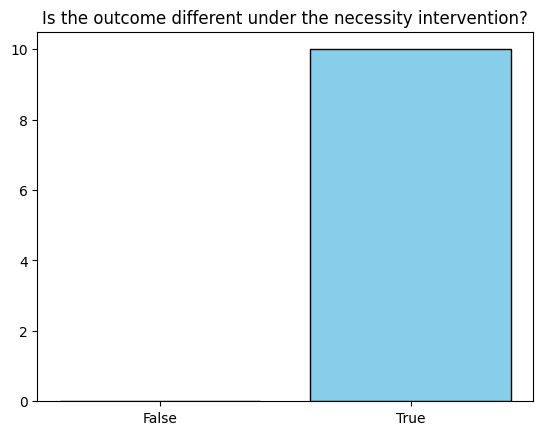

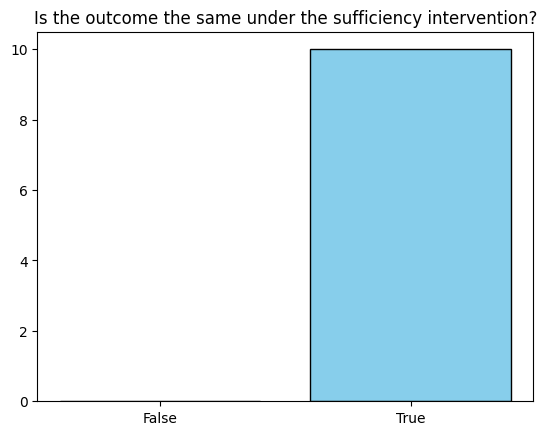

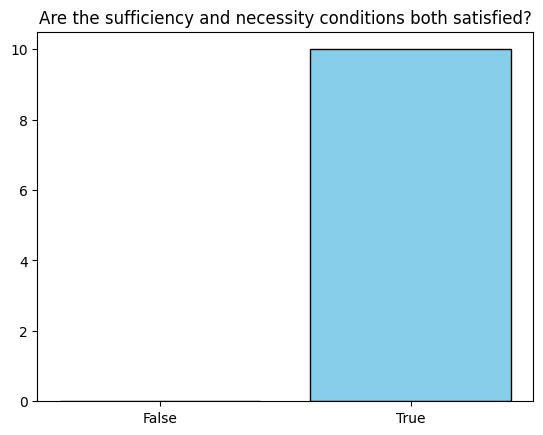

In [43]:
with ff_plated_observed_mwc:
    print(ff_plated_observed_nd.keys())
    necessity_counterfactual = gather(ff_plated_observed_nd['forest_fire']['value'],
    IndexSet(**{'match_dropped': {1}})).numpy()
    sufficiency_counterfactual = gather(ff_plated_observed_nd['forest_fire']['value'],
    IndexSet(**{'match_dropped': {2}})).numpy()

    nec_log = gather(ff_plated_observed_nd['__consequent__neq_forest_fire']['log_prob'],
    IndexSet(**{'match_dropped': {1}})).numpy()
    suf_log = gather(ff_plated_observed_nd['__consequent__eq_forest_fire']['log_prob'],
    IndexSet(**{'match_dropped': {2}})).numpy()
    nec_suf_log = gather(ff_plated_observed_nd['__consequent__eq_neq_forest_fire']['log_prob'],
    IndexSet(**{'match_dropped': {2}})).numpy()


nec_diff = [(item == 0.0) for item in nec_log.flatten()]
suf_same = [(item == 0.0) for item in suf_log.flatten()]
nec_suf_log = [(item == 0.0) for item in nec_suf_log.flatten()]

counter_nec = Counter(nec_diff)
counter_suf = Counter(suf_same)
counter_nec_suf = Counter(nec_suf_log)

labels = ['False', 'True']
values_nec = [counter_nec[False], counter_nec[True]]
values_suf = [counter_suf[False], counter_suf[True]]
values_nec_suf = [counter_nec_suf[False], counter_nec_suf[True]]


plt.bar(labels, values_nec, color='skyblue', edgecolor='black')
plt.title('Is the outcome different under the necessity intervention?')
plt.show()

plt.bar(labels, values_suf, color='skyblue', edgecolor='black')
plt.title('Is the outcome the same under the sufficiency intervention?')
plt.show()

plt.bar(labels, values_nec_suf, color='skyblue', edgecolor='black')
plt.title('Are the sufficiency and necessity conditions both satisfied?')
plt.show()


